In [3]:
! git clone https://github.com/angelgldh/rsv_modelling_transfer_learning.git

Cloning into 'rsv_modelling_transfer_learning'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 239 (delta 16), reused 22 (delta 9), pack-reused 209
Receiving objects: 100% (239/239), 5.97 MiB | 16.22 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [7]:
import os
os.chdir('/content/rsv_modelling_transfer_learning')

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import pickle
import shap

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [ ]:
import auxFuns.modelling
import auxFuns.EDA
importlib.reload(auxFuns.modelling)
importlib.reload(auxFuns.EDA)

<module 'auxFuns.EDA' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\EDA.py'>

# 1. Model selection
Feature selection using the following techniques:
- Backward stepwise selection
- Penalized regression
- Feature importance in random forest

Although not ideal, they are helpful to obtain the big picture of which models are worth trying

In [ ]:
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv')
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

# summary_function_rsv(rsv_predictors_df_v2)

# Extract a reduced sample of the data for modelling
# sample_size = 20000
sample_size = rsv_predictors_df_v2.shape[0]
sample_dedup_df = rsv_predictors_df_v2.sample(n = sample_size)

In [ ]:
df1 = sample_dedup_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters', 'n_tests_that_day'], axis = 1)

## 1.1 Backward stepwise selection

In [ ]:
# Naive approach to bakwards stepwise selection, exclusively to see which results are produced
X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_rsv(
    df1, input_test_size = 0.2, random_seed = 42, resampling_technique = None)

y_train_numeric = pd.Series([1 if label == 'Positive' else 0 for label in y_train])
X_pd = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns = get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv))

# First, produce the full model
model_full = sm.Logit(y_train_numeric, X_pd)
result = model_full.fit()

# Set the usual significance level at 0.05
sl = 0.05

# Main loop for backward selection
cols = get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv)
while len(cols) > 0:
    X_1 = X_pd[cols]
    model = sm.Logit(y_train_numeric, X_1)
    result = model.fit(disp=0)
    p_values = result.pvalues
    max_p_value = max(p_values)
    feature_with_p_max = p_values.idxmax()
    if max_p_value > sl:
        print(f'Predictor {feature_with_p_max} has been removed')
        cols.remove(feature_with_p_max)
    else:
        print('Backward selection process finished!')
        break

selected_features = cols
print(selected_features)

Resampling method chosen:

None
         Current function value: 0.123773
         Iterations: 35
Predictor calendar_year_2008 has been removed
Predictor calendar_year_2007 has been removed
Predictor calendar_year_2004 has been removed
Predictor calendar_year_2009 has been removed
Predictor key_comorbidities_2 has been removed
Predictor patient_regional_location_Unknown has been removed
Predictor Diabetes_complications_1 has been removed
Predictor any_immunodeficiency_1 has been removed
Predictor race_Pacific has been removed
Predictor Symptoms_and_signs__skin_and_subcutaneous_tissue_1 has been removed
Predictor Dementia_1 has been removed
Predictor CVD_1 has been removed
Predictor Asthma_1 has been removed
Predictor Symptoms_and_signs__cognition_perception_emotional_state_and_behaviour_1 has been removed
Predictor age_group_31-35 has been removed
Predictor marital_status_Single has been removed
Predictor age_group_41-45 has been removed
Predictor race_Unknown has been removed
Predicto

## 1.2. Penalized regression


In [ ]:
X_train_transformed_smote, y_train_smote, X_test_transformed_smote, y_test_smote, preprocessor_rsv = preprocess_and_resample_rsv(
    df1, input_test_size = 0.2, random_seed = 42, resampling_technique = None)

Resampling method chosen:

None


In [ ]:
classifier = LogisticRegression(penalty='l1', solver='saga', C= 0.05)
classifier.fit(X_train_transformed_smote, y_train_smote)

# Determine the coefficients of the L1 regression (names, values)
feature_names = get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv)
coef_dict = (dict(zip(feature_names, abs(classifier.coef_[0]))))

# Evaluating result of the model
y_pred = classifier.predict(X_test_transformed_smote)

optimal_threshold = find_optimal_moving_threshold(model = classifier, X_test = X_test_transformed_smote, y_test = y_test_smote)
__,__,__,__,__,__,__ = calculate_performance_metrics_rsv(trained_model = classifier, X_test = X_test_transformed_smote, y_test = y_test_smote,
                                                         threshold = optimal_threshold,
                                                         print_roc = False)

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal threshold: 0.09
Optimal f1: 0.19063004846526654


AUC Score: 0.7324429803927943
Precision / Positive predictive value: 0.1669024045261669
Specificity: 0.9646903662849949
Recall / sensitivity: 0.2222222222222222
Negative predictive value: 0.9749772796122387
Accuracy: 0.9417848013014176
F-1: 0.19063004846526654


In [ ]:
sorted(coef_dict.items(), key = lambda x: x[1], reverse = True)

[('sex_F', 2.1363480586289763),
 ('sex_M', 2.135390524314064),
 ('Bronchitis_1', 1.1165793958861374),
 ('any_symptom_1', 0.7246668867988667),
 ('Influenza_1', 0.7164293255988248),
 ('cosine', 0.6690079998484041),
 ('calendar_year_2022', 0.5650195898980706),
 ('General_symptoms_and_signs_1', 0.5108991575474107),
 ('sine', 0.43797193787726485),
 ('Symptoms_and_signs__digestive_system_and_abdomen_1', 0.4119548671833778),
 ('Acute_upper_respiratory_infection_1', 0.40209622053335403),
 ('n_symptoms', 0.39459094406203565),
 ('healthcare_seeking_1', 0.32528512026595113),
 ('patient_regional_location_South', 0.2963670351770392),
 ('COPD_1', 0.2925309121971603),
 ('previous_test_daydiff', 0.21084803218119647),
 ('patient_regional_location_Northeast', 0.1991655485593708),
 ('prev_positive_rsv', 0.18841238318791875),
 ('calendar_year_2020', 0.11664523009181191),
 ('calendar_year_2018', 0.1045058039938296),
 ('mild_liver_disease_1', 0.09432482197763749),
 ('AIDS_1', 0.0895770676859015),
 ('marital

## 1.3 Feature importance in random forest

In [ ]:
X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_rsv(df1,
                                                                          input_test_size = 0.2, random_seed = 42
                                                                          )

Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 5},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.27547627288607385
Optimal threshold: 0.38
Optimal f1: 0.2565597667638484


AUC Score: 0.6990886707488058
Precision / Positive predictive value: 0.567741935483871
Specificity: 0.9959834542293627
Recall / sensitivity: 0.1657250470809793
Negative predictive value: 0.9740282581931172
Accuracy: 0.9703695096444341
F-1: 0.2565597667638484


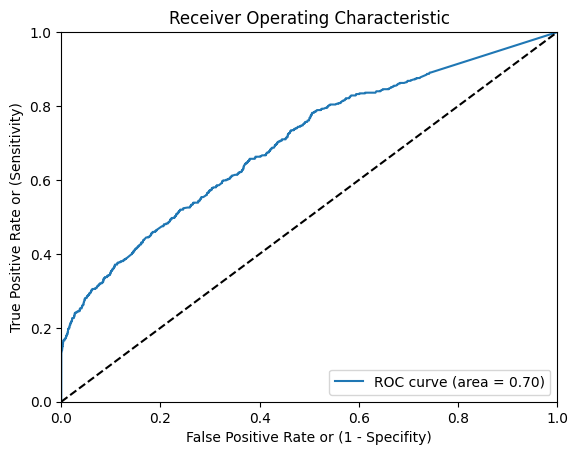

In [ ]:
random_seed = 42
cost_sensitive = True

if cost_sensitive:
    weight_dict = {"Negative": 1,
                   "Positive": 5}
    model_class = RandomForestClassifier(class_weight= weight_dict,
                                         random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None,
                                         random_state= random_seed)

param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, pos_label = 'Positive')
n_cv_folds = 5

model_rf = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)

# Evaluate the performance of the model
optimal_threshold = find_optimal_moving_threshold(model = model_rf, X_test = X_test_transformed, y_test = y_test)

__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model_rf, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold,
                                                         print_roc = True)


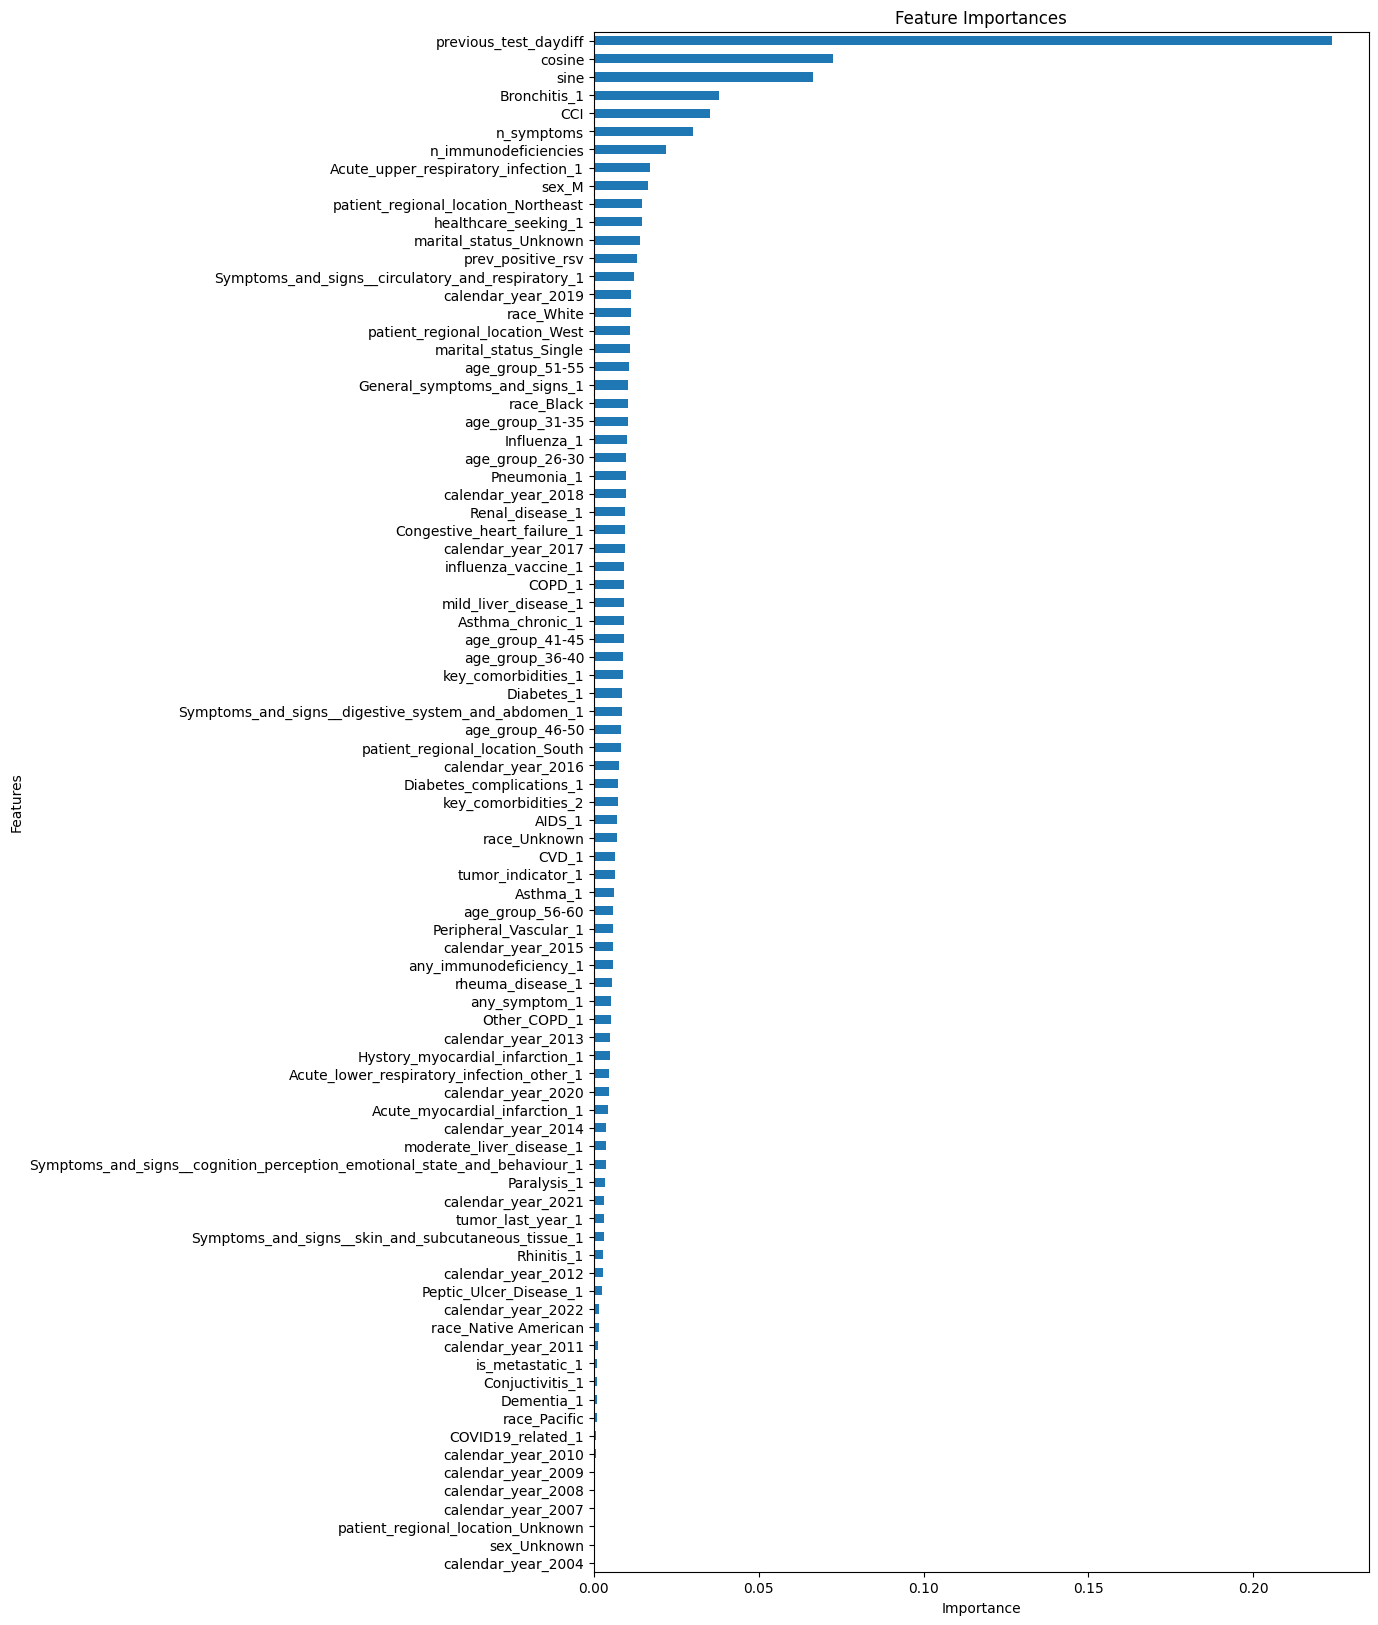

In [ ]:
importance_df = feature_importance_rf_rsv(preprocessor_rsv, trained_model = model_rf)

In [ ]:
importance_df.loc[importance_df['feature'] == 'AIDS_1']

,feature,importance
51,AIDS_1,0.007011


Overall, the three methods point towards the same (roughly) features:

In [ ]:
selected_features = ['sex', 'marital_status', 'patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year',
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies',
                     'tumor_indicator','tumor_last_year',
                     'season']

# 2. Resampling techniques and drivers of positivity

In-depth study of the predictors driving positivity in multiple sampling examples.

As a first approach:

- Resample the data following various techniques > fit a random forest > see which features are more important in each case (and SHAP values too)

In [10]:
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

rsv_predictors_df_v2.shape

# summary_function_rsv(rsv_predictors_df_v2)

# Extract a reduced sample of the data for modelling
# sample_size = 80000
# sample_v2_df = rsv_predictors_df_v2.sample(n = sample_size, random_state=42)

sample_v2_df = rsv_predictors_df_v2

In [11]:
# selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
#                      'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
#                      'COPD','AIDS','Asthma_chronic','CCI',
#                      'sine','cosine','calendar_year',
#                      'healthcare_seeking', 'influenza_vaccine',
#                      'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies',
#                      'tumor_indicator','tumor_last_year',

#                      'season',
#                      'n_tests_that_day']
# selected_features.append('RSV_test_result')
selected_features = sample_v2_df.drop(['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters'], axis = 1).columns
df1 = sample_v2_df[selected_features]

input_test_size = 0.2
random_seed = 42

resampling_techniques = ['over','under', 'smotenc', 'downsample_upweight']
ratios = [0.05, 0.3, 0.5, 0.8, 1]

In [ ]:
# Goal: generate various models and see the importances of different features in each of these models
df1 = sample_v2_df[selected_features]

input_test_size = 0.2
random_seed = 42

resampling_techniques = ['over','under', 'smotenc', 'downsample_upweight']
ratios = [0.05, 0.3, 0.5, 0.8, 1]

results_dict = {}


for resam in resampling_techniques:

    results_dict[resam] = {}

    for r in ratios:
        print('------------------------------------------------------------------')
        print(f'Training on resampling {resam} and ratio: {r}')

        if resam == 'None':
            resam = None

        X_train, y_train, X_test, y_test, sample_weights, preprocessor_rsv = preprocess_and_resample_rsv(
            df1, input_test_size = input_test_size, random_seed = random_seed, resampling_technique = resam, ratio_maj_min = r)


        model_class = RandomForestClassifier(class_weight= None,
                                             random_state= random_seed)
        param_grid = {
            'n_estimators': [7, 14],
            'max_depth': [10, 20],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [1, 4]
        }
        target_scorer = make_scorer(f1_score, average='binary', pos_label = 'Positive')
        n_cv_folds = 5
        model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                                X_train = X_train, y_train = y_train, sample_weights = sample_weights)

        optimal_threshold = find_optimal_moving_threshold(model = model1, X_test = X_test, y_test = y_test)
        roc_auc,__,__,__,__,__,f1,__ = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test, y_test = y_test, threshold = optimal_threshold, print_roc = False, print_pr = False)

        importance_df = feature_importance_rf_rsv(preprocessor_rsv = preprocessor_rsv, trained_model = model1, plot_importances = False)

        results_dict[resam][r] = {
            'model': model1,
            'thres': optimal_threshold,
            'roc_auc': roc_auc,
            'f1': f1,
            'importance_df': importance_df,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        }

        # Saving the dictionary.
        with open('C:/Users/angel/Documents/VSCode/rsv_modelling_transfer_learning/datasets/processed/results_dict_v2.pkl', 'wb') as handle:
            pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)




### Load the results

In [13]:
# previous cells should have been run in advance to have the results_dict dictionary in the target folder

processed_path = os.getcwd() + '/datasets/processed'
with open(processed_path + '/' + 'results_dict.pkl', 'rb') as handle:
    loaded_dict = pickle.load(handle)

### Study of the importance

Importance in the **under-sampling** setting

- The same 4 features always appear in top 5: sine, cosine, n_tests_that_day, previous_test_day_diff
- Bronchitis and CCI are the other ones to occupy top 5
- Top 5-10: Acute_upper_respiratory_infection, n_immunodeficiencies,n_symptoms appear recurrently
- Healthcare_seeking appears specially for high rebalancing ratios (>0.5)
- Top 10-15: General_symptoms_and_signs_1, prev_positive_rsv, Influenza
- At this point (top 10-15) is where demographic factors start to appear (race, age, marital status)
- Top 15-20: demographic factors and some symptoms_and_signs
- Top 20-25: mostly demographic factors
- Some other predictors that appear sometimes are Pneumonia, COPD, Asthma_chornic, Chronic heart disease

In [ ]:
# Study the results of dowm-sampling !
undersampling_results = loaded_dict['under']

for key, value in undersampling_results.items():
    print('-------------------------------------')
    print(f'For undersampling at ratio {key}: ')
    importance_df = value['importance_df']
    importance_df = importance_df.sort_values(by = 'importance', ascending = False)

    print(importance_df[1:20])

    # importance_df.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(10, 20))

    # plt.title('Feature Importances')
    # plt.xlabel('Importance')
    # plt.ylabel('Features')
    # plt.show()


-------------------------------------
For undersampling at ratio 0.05: 
                                feature  importance
82                previous_test_daydiff    0.142217
85                               cosine    0.053506
84                                 sine    0.047164
79                                  CCI    0.028558
80                           n_symptoms    0.024890
22                         Bronchitis_1    0.024569
83                 n_immunodeficiencies    0.020537
81                    prev_positive_rsv    0.011849
19  Acute_upper_respiratory_infection_1    0.010020
78                                sex_M    0.009833
7   patient_regional_location_Northeast    0.009781
51                 healthcare_seeking_1    0.009712
73                   calendar_year_2019    0.009381
6                marital_status_Unknown    0.009116
5                 marital_status_Single    0.008850
15                      age_group_46-50    0.008729
72                   calendar_year_2018    0

### SHAP values > drivers of positivity

- SHAP values **under-sampling**

-------------------------------------
(SHAP VALUES) undersampling at ratio 0.05: 
Resampling method chosen:

Undersampling
building shap values...


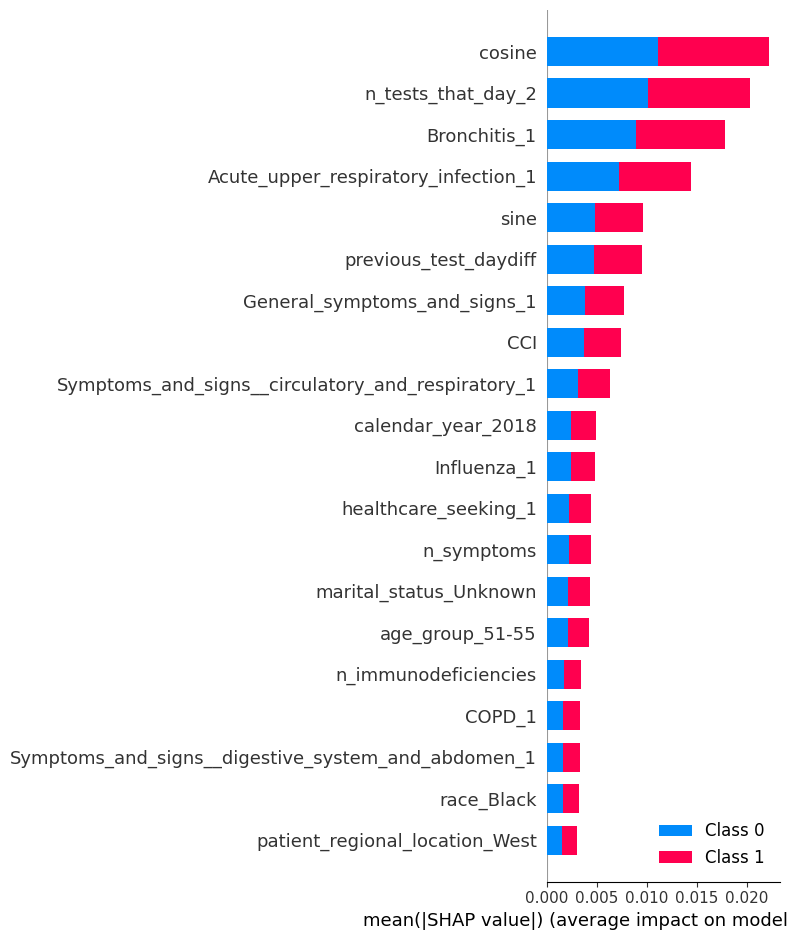

-------------------------------------
(SHAP VALUES) undersampling at ratio 0.3: 
Resampling method chosen:

Undersampling
building shap values...


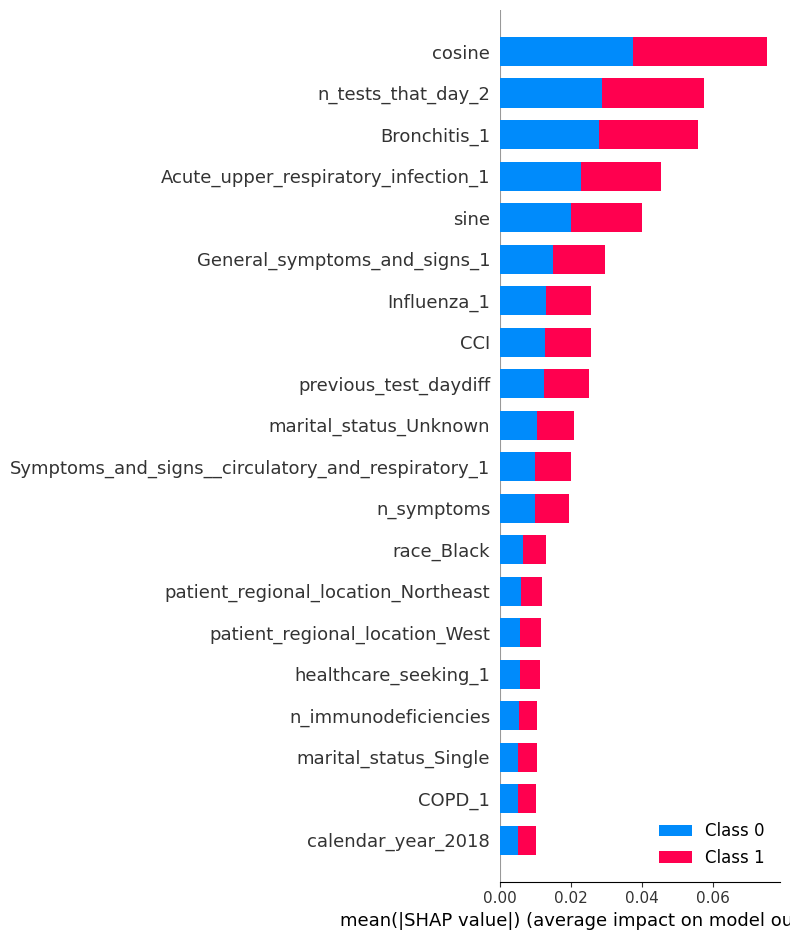

-------------------------------------
(SHAP VALUES) undersampling at ratio 0.5: 
Resampling method chosen:

Undersampling
building shap values...


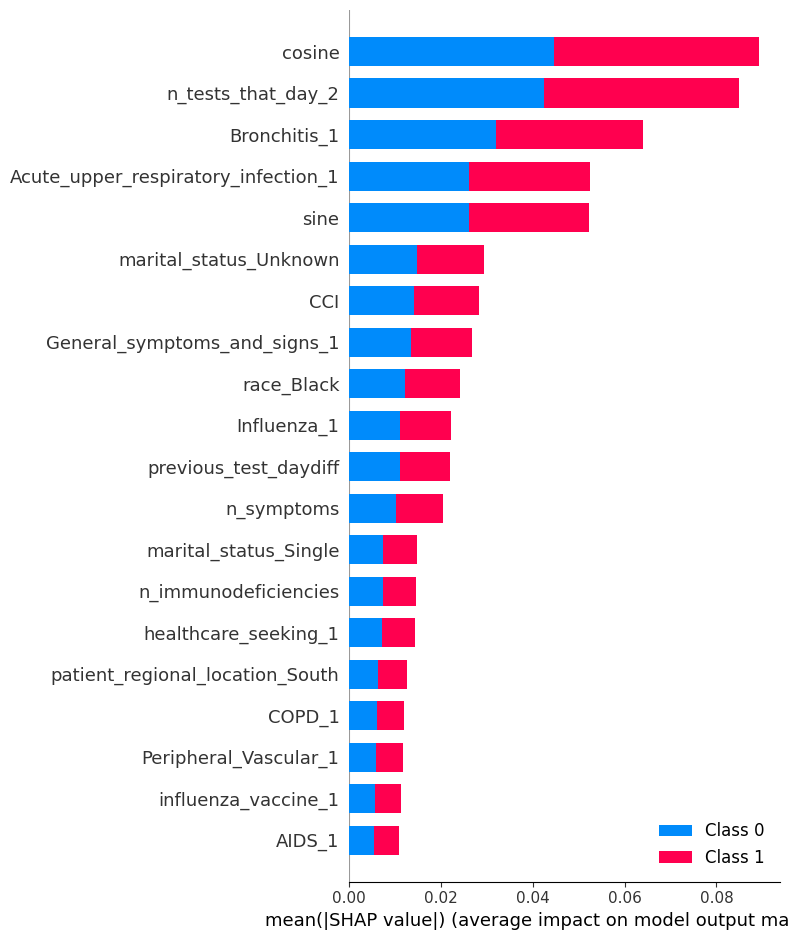

-------------------------------------
(SHAP VALUES) undersampling at ratio 0.8: 
Resampling method chosen:

Undersampling
building shap values...


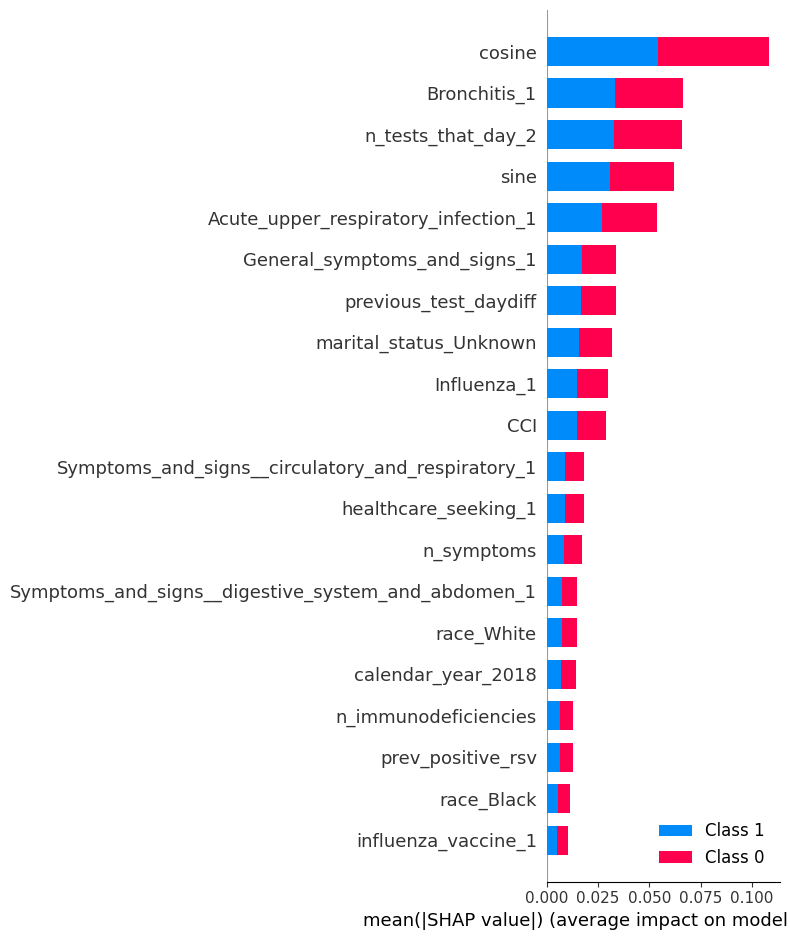

-------------------------------------
(SHAP VALUES) undersampling at ratio 1: 
Resampling method chosen:

Undersampling
building shap values...


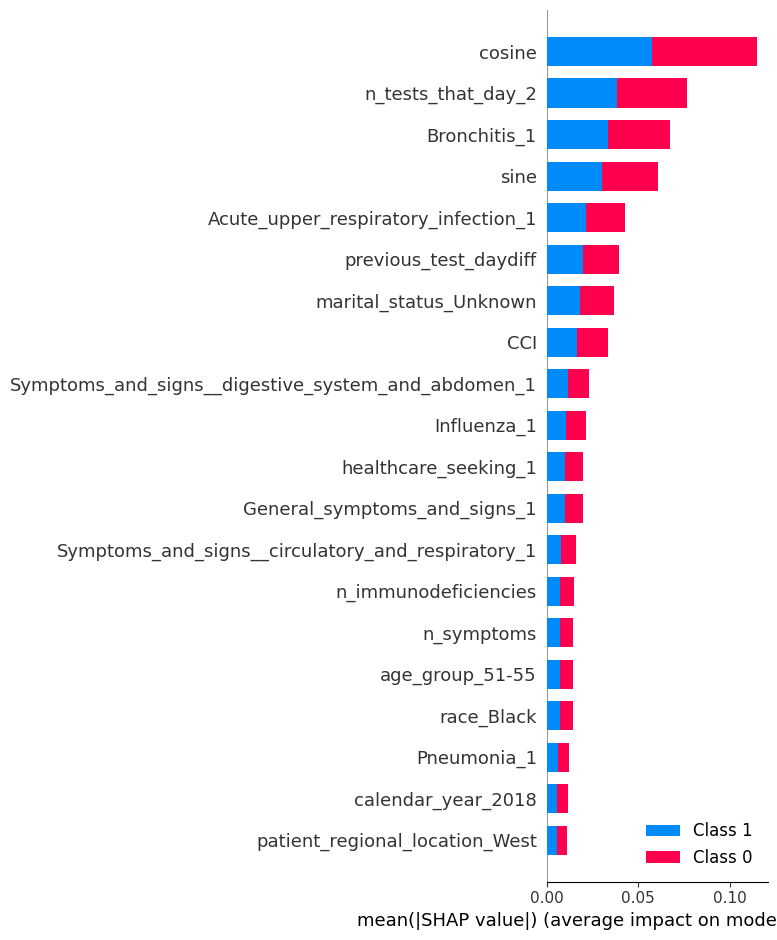

In [21]:
# Study the results of dowm-sampling !
undersampling_results = loaded_dict['under']

for key, value in undersampling_results.items():
    print('-------------------------------------')
    print(f'(SHAP VALUES) undersampling at ratio {key}: ')
    rf_model = value['model'].best_estimator_
    r = key

    # As the random seed is kept, the results are reproducible
    X_train, y_train, X_test, y_test, sample_weights, preprocessor_rsv = preprocess_and_resample_rsv(
            df1, input_test_size = input_test_size, random_seed = random_seed, resampling_technique = 'under', ratio_maj_min = r)

    print('building shap values...')
    explainer = shap.TreeExplainer(rf_model, n_jobs = -1, approximate=True)
    shap_values = explainer.shap_values(X_test.toarray())

    shap.summary_plot(shap_values, features=X_test.toarray(),
                      feature_names=get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv), plot_type='bar')

- SHAP values for **dowmsapling and upweighting**

-------------------------------------
(SHAP VALUES) downsample_upweight at ratio 0.05: 
Resampling method chosen:

Undersampling
building shap values...


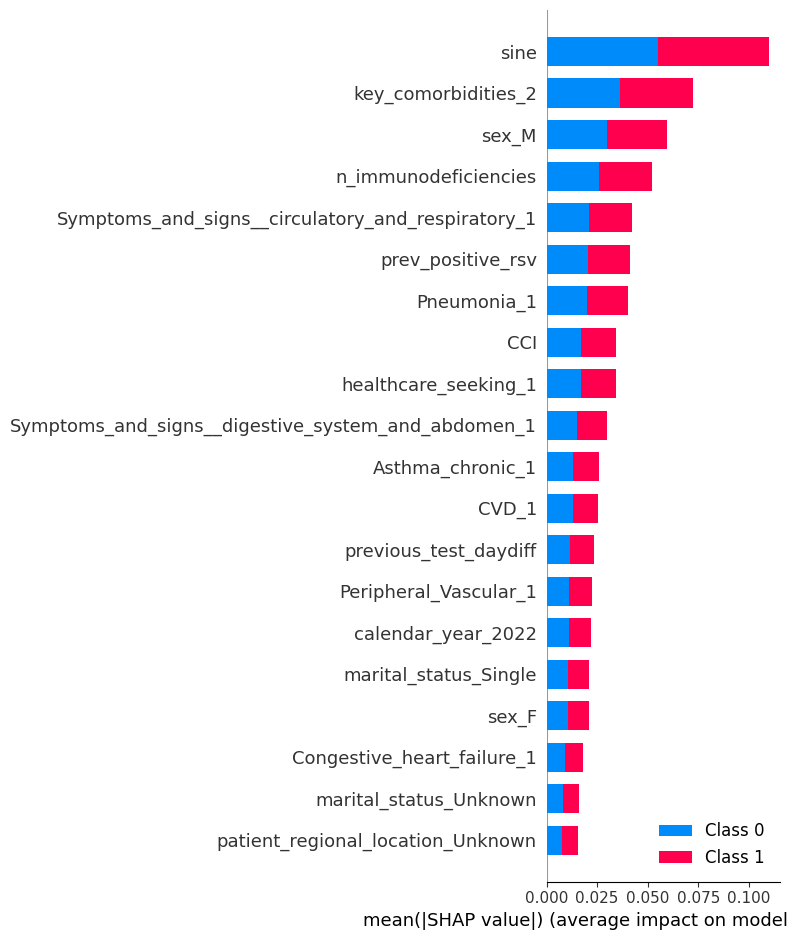

-------------------------------------
(SHAP VALUES) downsample_upweight at ratio 0.3: 
Resampling method chosen:

Undersampling
building shap values...


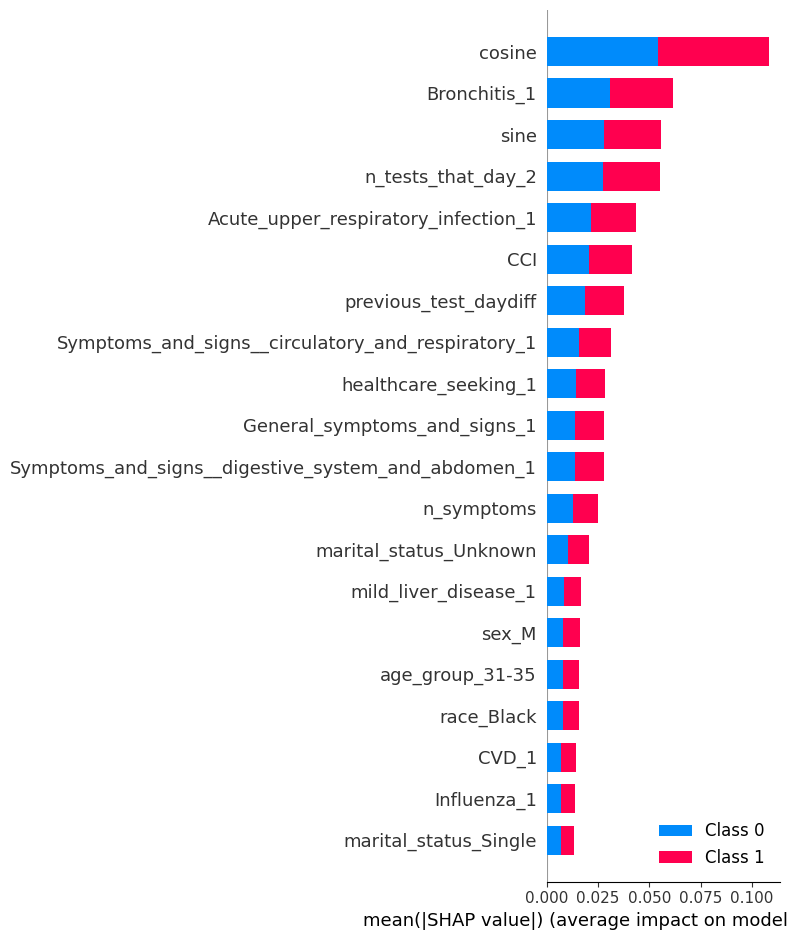

-------------------------------------
(SHAP VALUES) downsample_upweight at ratio 0.5: 
Resampling method chosen:

Undersampling
building shap values...


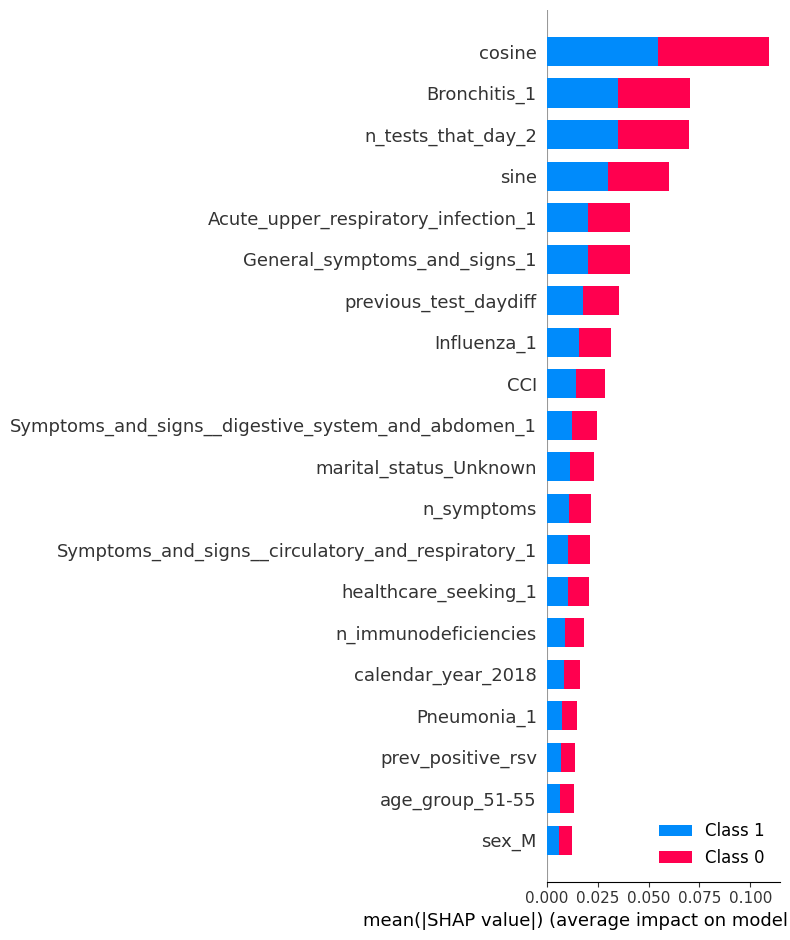

-------------------------------------
(SHAP VALUES) downsample_upweight at ratio 0.8: 
Resampling method chosen:

Undersampling
building shap values...


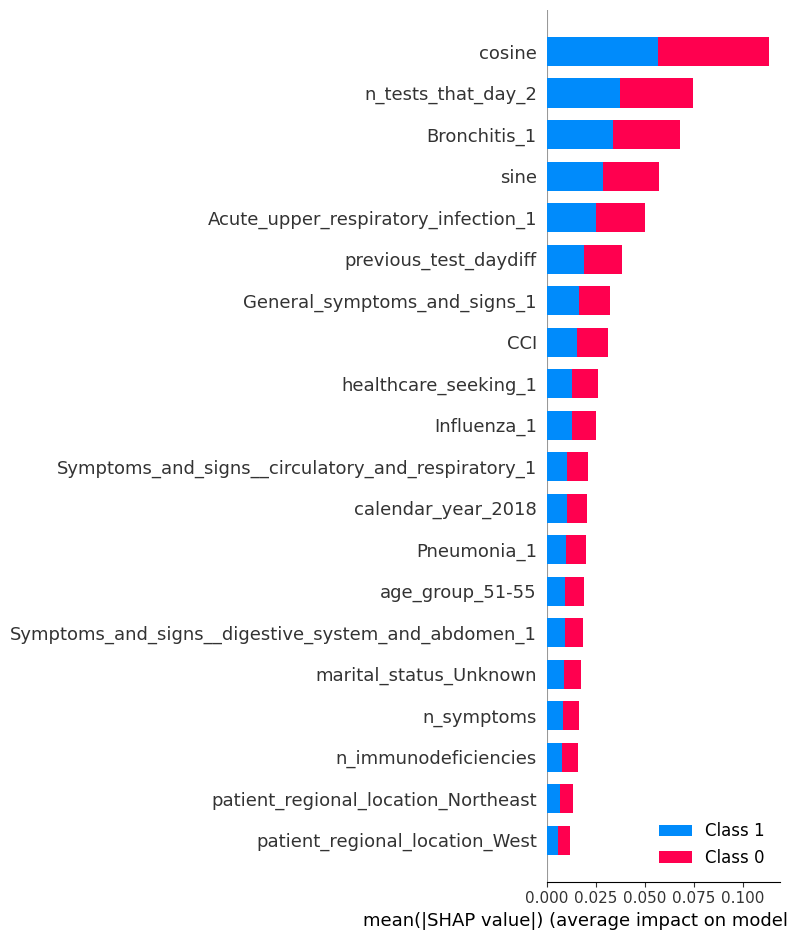

-------------------------------------
(SHAP VALUES) downsample_upweight at ratio 1: 
Resampling method chosen:

Undersampling
building shap values...


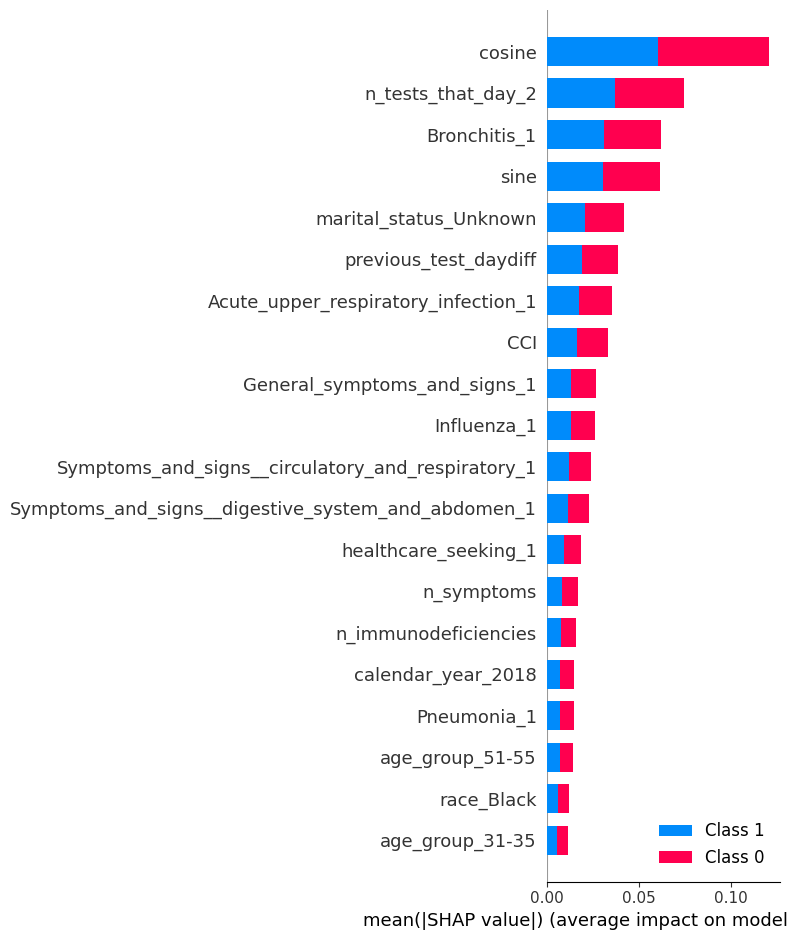

In [15]:
# Study the results of over-sampling !
down_upweight_results = loaded_dict['downsample_upweight']

for key, value in down_upweight_results.items():
    print('-------------------------------------')
    print(f'(SHAP VALUES) downsample_upweight at ratio {key}: ')
    rf_model = value['model'].best_estimator_
    r = key

    # As the random seed is kept, the results are reproducible
    X_train, y_train, X_test, y_test, sample_weights, preprocessor_rsv = preprocess_and_resample_rsv(
            df1, input_test_size = input_test_size, random_seed = random_seed, resampling_technique = 'downsample_upweight', ratio_maj_min = r)

    print('building shap values...')
    explainer = shap.TreeExplainer(rf_model, n_jobs = -1, approximate=True)
    shap_values = explainer.shap_values(X_test.toarray())

    shap.summary_plot(shap_values, features=X_test.toarray(),
                      feature_names=get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv), plot_type='bar')